In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf

from scipy import signal
from scipy import stats

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


from new_stations import *
from time_series_model import *


## Load data, add features, subset, and define proposed locations

In [2]:
#load the data
data, weather = load_data()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [3]:
#add features to the dataset
data = feature_addition(data)

In [4]:
#subset the dataframe for desired city
city = model_city(data,1)

In [5]:
#cdf = current month df
#ndf = next month df
cdf, ndf = month_sep(city, 2017, 9)

In [6]:
#proposed stations
ps = new_stn_coords(cdf, ndf)
ps

[130.0, 118.0]

In [7]:
df1 = cdf

In [8]:
df2 = ndf

In [9]:
qtr = days_for_ts(city, cdf,3)

/Users/michellehoang/galvanize/Capstone_Project/time_series_model.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  tsdf['days'] = 1
/Users/michellehoang/galvanize/Capstone_Project/time_series_model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  tsdf['days'][tsdf.month == mon] = tsdf.day * mult
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:8672: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_i

## Identify neighbor stations

In [10]:
def knn_proposed_stn(qtr, df1, df2, proposed_stn, num_neighbors = 3):
    
    #all coordinates for each trip
    coordinates = np.array(df1[['start_station_longitude', 'start_station_latitude']])
    #unique coords in df1
    unique_coords = np.unique(coordinates, axis = 0)
    #get the id and coords for current month
    id_coord_df1 = stn_coords(df1)
    id_coord_df2 = stn_coords(df2)
    knn_dict = {}
    for p in proposed_stn:
        dist = euclidean_distance(id_coord_df2.get(p), unique_coords)
        potential_neighbors = unique_coords[np.argsort(dist)]
        neighbors = np.array([0,0])
        for pot in potential_neighbors:
            sid = qtr.start_station_id[(qtr.start_station_longitude==pot[0])&(qtr.start_station_latitude==pot[1])].unique()[0]
#             if len(cdf.days[cdf.start_station_id==sid].unique())>10:
            if len(qtr.days[qtr.start_station_id==sid].unique())>30:
                neighbors = np.vstack((neighbors, pot))
        neighbors = neighbors[1:num_neighbors+1]


    #         k = df.start_station_id[(df.start_station_longitude == id_coord_df2.get(p)[0]) &(df.start_station_latitude == id_coord_df2.get(p)[1])].iloc[0]
        v = []
        for i in range(num_neighbors):
            knn_id = qtr.start_station_id[(qtr.start_station_longitude == neighbors[i][0]) &(qtr.start_station_latitude == neighbors[i][1])].iloc[0]
            v.append(int(knn_id))
        knn_dict[int(p)] = v
    return knn_dict, id_coord_df1, id_coord_df2

In [11]:
#neighbors for each proposed location
#id and coordinate combo for each station
neighbors, id_coord1, id_coord2= knn_proposed_stn(qtr, cdf, ndf, ps)

In [12]:
neighbors

{130: [126, 116, 115], 118: [119, 105, 106]}

In [13]:
qtr.days[qtr.start_station_id==115].unique()

array([120, 116, 112, 108, 104, 100,  96,  92,  88,  84,  80,  76,  72,
        68,  64,  60,  56,  52,  48,  44,  40,  36,  32,  28,  24,  20,
        16,  12,   8,   4,  93,  90,  87,  81,  78,  75,  69,  66,  63,
        57,  54,  51])

In [14]:
def plt_neighbors(cdf, neighbors, coords):
    for k, v in neighbors.items(): 
        print("The origin station is {}.".format(k))
        n1 = int(neighbors.get(k)[0])
        n2 = int(neighbors.get(k)[1])
        n3 = int(neighbors.get(k)[2])
        print("The 3 closest stations are: {}, {}, {}".format(n1,n2,n3))
        plt.figure(figsize = (10,10))
        
        
        #lims for SF
        ll,rr = -122.50, -122.36
        bb = 37.73
#         #lims for OAK
#         ll,rr = -122.33, -122.19
#         bb = 37.76
        plt.xlim(ll,rr)
        plt.ylim(bb, bb+(rr-ll))
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title("Map of Ford GoBike stations in San Francisco")
        plt.scatter(cdf.end_station_longitude, cdf.end_station_latitude, s=1, c=('r'))
        plt.scatter(coords.get(k)[0], coords.get(k)[1], s=50, marker='x', c=('b'))

        for st in neighbors.get(k):
            plt.scatter(coords.get(st)[0],coords.get(st)[1], s= 20, c='g')
        plt.show()



The origin station is 130.
The 3 closest stations are: 126, 116, 115


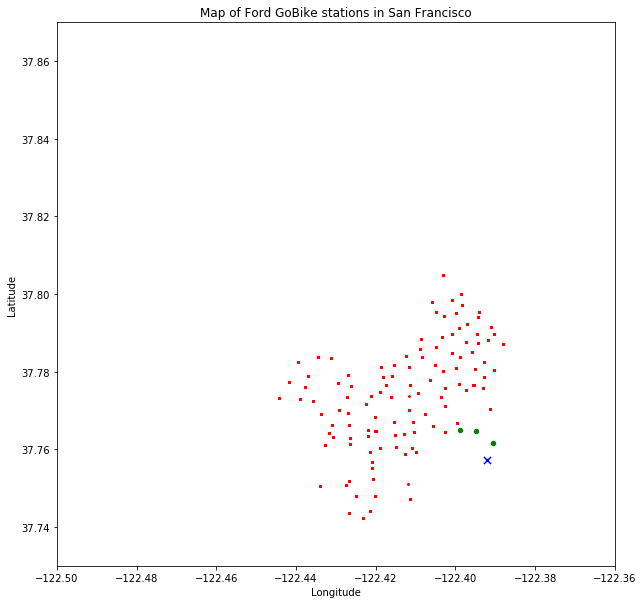

The origin station is 118.
The 3 closest stations are: 119, 105, 106


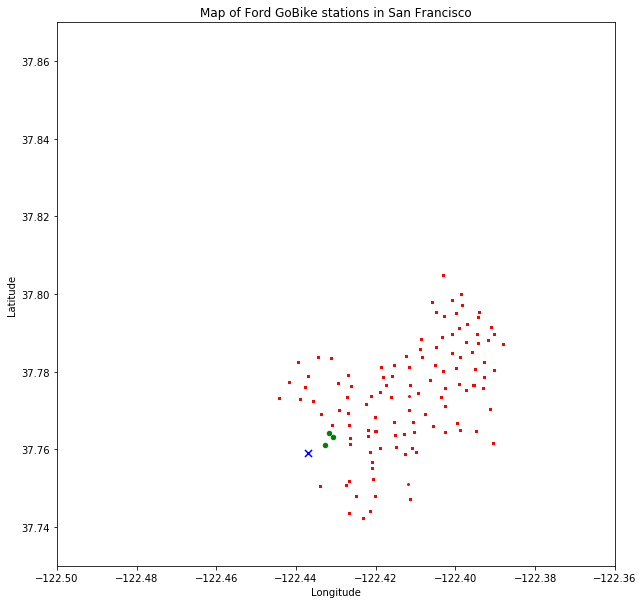

In [15]:
plt_neighbors(cdf, neighbors, id_coord2)

In [16]:
# t = 230
# print("The origin station is {}.".format(t))
# print("The 3 closest neighbors are: {}, {}, {}".format(int(neighbors.get(t)[0]),int(neighbors.get(t)[1]),int(neighbors.get(t)[2])))
# plt.figure(figsize = (10,10))
# ll,rr = -122.50, -122.36
# bb = 37.73
# plt.xlim(ll,rr)
# plt.ylim(bb, bb+(rr-ll))
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.title("Map of Ford GoBike stations in San Francisco")
# plt.scatter(qtr.end_station_longitude, qtr.end_station_latitude, s=1, c=('r'))
# plt.scatter(id_coord.get(t)[0], id_coord.get(t)[1], s=20, marker='x', c=('b'))

# for st in neighbors.get(t):
#     plt.scatter(id_coord.get(st)[0],id_coord.get(st)[1], s= 10, c='g')
# plt.show()



In [17]:
def plt_stn():
    row_sze = len(neighbors)
    col_sze = len(next(iter(neighbors.values())))
    rnge = row_sze*col_sze
    fig = plt.figure(figsize=(10,10))
    graph = 1
    for k, v in neighbors.items():
        num = 1
        for s_id in v:
            plt.subplot(rnge,1,graph)
            plt.subplots_adjust(top=10, bottom =5)
            plt.xlabel("days")
            plt.ylabel("trips per day")
            plt.title("This is station {}, and it is neighbor #{} for station {}".format(s_id, num, k))
            ts = days_count(qtr, s_id)
            plt.plot(ts[:,0],ts[:,1])
            num+=1
            graph+=1
            

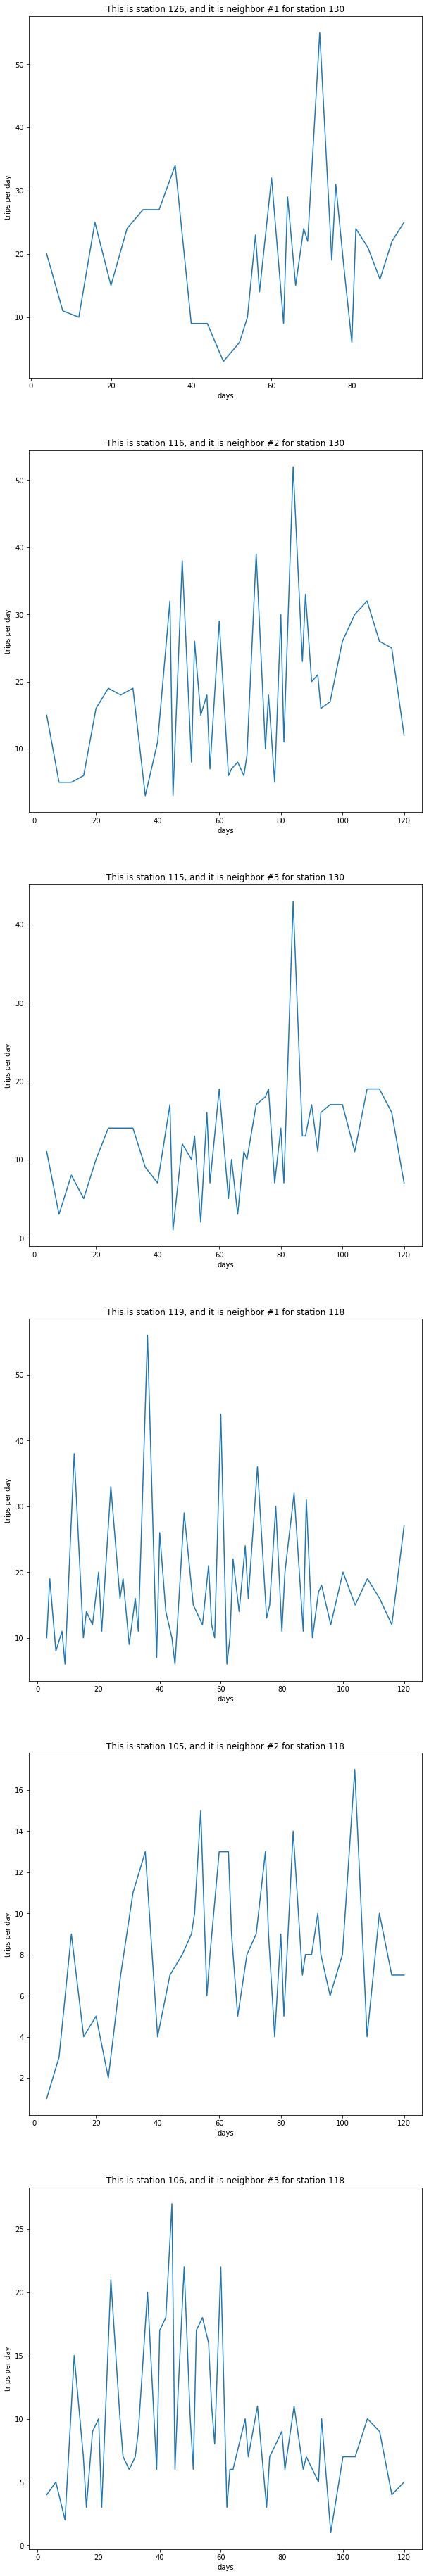

In [18]:
plt_stn()

## Testing Stations/Debugging

In [19]:
neighbors


{130: [126, 116, 115], 118: [119, 105, 106]}

In [20]:
test_station=116

In [21]:
#array of trips per each day for test_station
ts = days_count(qtr, test_station)
ts

array([[  4,  15],
       [  8,   5],
       [ 12,   5],
       [ 16,   6],
       [ 20,  16],
       [ 24,  19],
       [ 28,  18],
       [ 32,  19],
       [ 36,   3],
       [ 40,  11],
       [ 44,  32],
       [ 45,   3],
       [ 48,  38],
       [ 51,   8],
       [ 52,  26],
       [ 54,  15],
       [ 56,  18],
       [ 57,   7],
       [ 60,  29],
       [ 63,   6],
       [ 64,   7],
       [ 66,   8],
       [ 68,   6],
       [ 69,   9],
       [ 72,  39],
       [ 75,  10],
       [ 76,  18],
       [ 78,   5],
       [ 80,  30],
       [ 81,  11],
       [ 84,  52],
       [ 87,  23],
       [ 88,  33],
       [ 90,  20],
       [ 92,  21],
       [ 93,  16],
       [ 96,  17],
       [100,  26],
       [104,  30],
       [108,  32],
       [112,  26],
       [116,  25],
       [120,  12]])

In [22]:
tseries = pd.Series(ts[:,1])

In [23]:
tseries.values

array([15,  5,  5,  6, 16, 19, 18, 19,  3, 11, 32,  3, 38,  8, 26, 15, 18,
        7, 29,  6,  7,  8,  6,  9, 39, 10, 18,  5, 30, 11, 52, 23, 33, 20,
       21, 16, 17, 26, 30, 32, 26, 25, 12])

In [24]:
#test to see if the series is stationary
test = sm.tsa.stattools.adfuller(tseries)
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.04


In [25]:
tseries_diffed = tseries.diff()[1:]

In [26]:
sm.tsa.stattools.adfuller(tseries_diffed)[1]

2.7808533737841144e-07

In [27]:
sm.tsa.stattools.adfuller(tseries_diffed)[1]<0.05

True

In [28]:
def stationary_convert(series, pvalue=0.05):
    test = sm.tsa.stattools.adfuller(series)
    if test[1] > pvalue:
        tseries_diffed = tseries.diff()[1:]
        return tseries_diffed
    return series

In [29]:
tseries_diff = stationary_convert(tseries)
sm.tsa.stattools.adfuller(tseries_diff)[1]<0.05

True

In [30]:
trip_vals = tseries.values
trip_vals

array([15,  5,  5,  6, 16, 19, 18, 19,  3, 11, 32,  3, 38,  8, 26, 15, 18,
        7, 29,  6,  7,  8,  6,  9, 39, 10, 18,  5, 30, 11, 52, 23, 33, 20,
       21, 16, 17, 26, 30, 32, 26, 25, 12])

In [31]:
trip_model = ARIMA(trip_vals, order=(3, 1, 0)).fit()

In [32]:
predictions = trip_model.predict(75, 85, typ='levels')
predictions

array([24.20838785, 17.8086277 , 22.92286134, 18.79994048, 22.57019398,
       20.14714458, 22.47649217, 21.06351603, 22.62077193, 21.839553  ,
       22.8944098 , 22.50407083, 23.25233051, 23.10422919, 23.66156142,
       23.6635897 , 24.1027902 , 24.19784416, 24.56380398, 24.71650705,
       25.03708761, 25.22551447, 25.51797273, 25.72853731, 26.00356881,
       26.22785181, 26.49208412, 26.72486825, 26.98240846, 27.22046063,
       27.47385382, 27.71517054, 27.96599388, 28.20933358, 28.45856442,
       28.70315775, 28.95140173, 29.19677191, 29.44440435, 29.69025594,
       29.93750942, 30.18365932, 30.43067796])

In [33]:
test = np.append(trip_vals, predictions)

In [34]:
test1 = pd.Series(test)

Observations: 23
Training Observations: 13
Testing Observations: 10
Observations: 33
Training Observations: 23
Testing Observations: 10
Observations: 43
Training Observations: 33
Testing Observations: 10


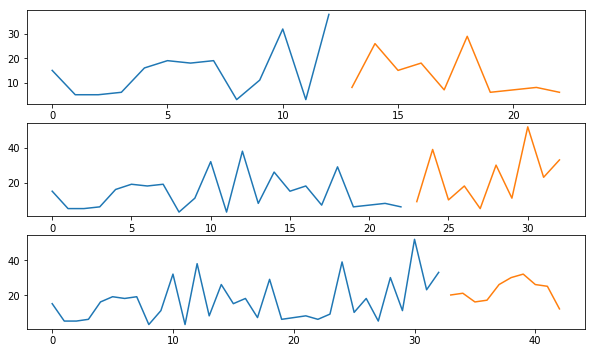

In [35]:
tseries = pd.Series(ts[:,1])
tscv = TimeSeriesSplit(n_splits=3)
fig = plt.figure(figsize=(10,10))
index = 1
for train_index, test_index in tscv.split(tseries):
    train = tseries[train_index]
    test = tseries[test_index]

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(5,1,index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    index += 1
plt.show()

In [36]:
def ARIMA_pred(arr, p=3, d=1, q=1):
    tseries = pd.Series(arr[:,1])
    tseries = stationary_convert(tseries)
    tscv = TimeSeriesSplit(n_splits=3)
    fig = plt.figure(figsize=(10,10))
    index = 1
    
    actual = []
    mean_mse= np.array([])
    for train_index, test_index in tscv.split(tseries):
        train = tseries[train_index]
        test = tseries[test_index]

        train_vals = train.values
#         trip_model = ARIMA(train_vals, order=(p, d, q)).fit()
        try:
            trip_model = ARIMA(train_vals, order=(p, d, q)).fit()
        except:
            train_vals = stationary_convert(train_vals)
            trip_model = ARIMA(train_vals, order=(p, d, q)).fit()
        train_sze = len(train)
        predictions = trip_model.predict(train_sze, train_sze+len(test)-1, typ='levels')
        
        #calculate mean squared error
        mse = mean_squared_error(predictions, np.array(test))
        mean_mse = np.append(mean_mse, mse)
        
        #combine to plot on same graph
        combined = np.append(train_vals, predictions)
        combined = pd.Series(combined)
        plt.subplot(3,1,index)
        plt.xlabel('Days')
        plt.ylabel('Trip Counts')
        plt.title('This has a mean squared error of {}'.format(mse))
        plt.plot(combined.index[:train_sze], combined[:train_sze], label="train")
        plt.plot(combined.index[train_sze:], combined[train_sze:], label='predicted')
# #         plt.plot(test)


# #         print (np.array(test))
# # #         print(len(train_index))
# # #         print (test_index)
#         print (predictions)
        
        index +=1
    avg_mse = mean_mse.mean()
    return avg_mse

In [37]:
#test to see if the series is stationary
test = sm.tsa.stattools.adfuller(ts[:,1])
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.04


In [38]:
def best_ARIMA_param(arr):
    max_param = 3
    score = np.array([0,0,0,0])
    for p in range(1,max_param+1):
        for d in range(1,max_param+1):
            for q in range(1,max_param+1):
                try:
                    mse = ARIMA_pred(arr, p, d, q)
                    score_data = np.array([p,d,q,mse])
                    score = np.vstack((score, score_data))
                except: 
                    print("The hyper parameters {}, {}, and {} did not work.".format(p, d, q))

    print("This is the array of scores")
    return score[1:]

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


The hyper parameters 1, 1, and 2 did not work.
The hyper parameters 1, 1, and 3 did not work.
The hyper parameters 1, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


The hyper parameters 1, 2, and 3 did not work.
The hyper parameters 1, 3, and 1 did not work.
The hyper parameters 1, 3, and 2 did not work.
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:648: RuntimeWarning: divide by zero encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:620: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:622: RuntimeWarning:

The hyper parameters 2, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages

The hyper parameters 2, 2, and 3 did not work.
The hyper parameters 2, 3, and 1 did not work.
The hyper parameters 2, 3, and 2 did not work.
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


The hyper parameters 3, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

The hyper parameters 3, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


The hyper parameters 3, 2, and 3 did not work.
The hyper parameters 3, 3, and 1 did not work.
The hyper parameters 3, 3, and 2 did not work.
The hyper parameters 3, 3, and 3 did not work.
This is the array of scores


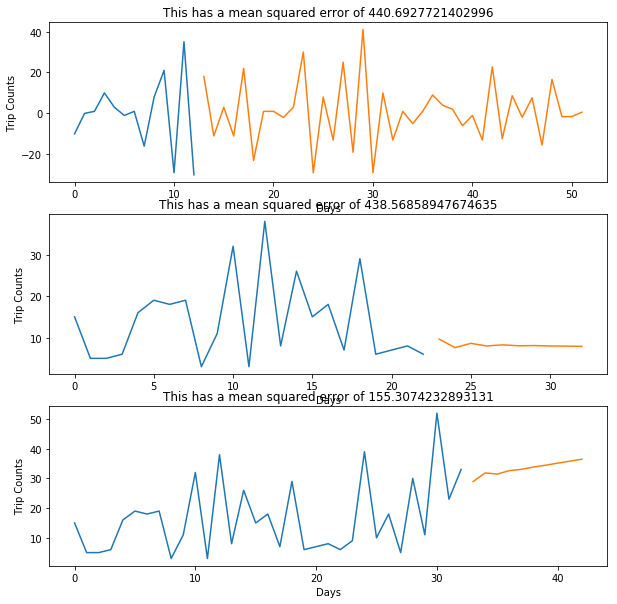

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

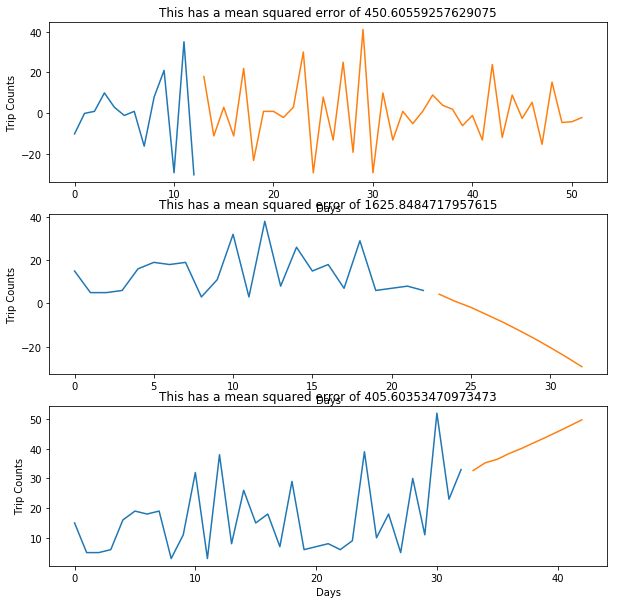

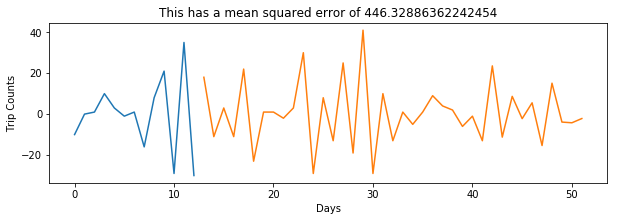

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

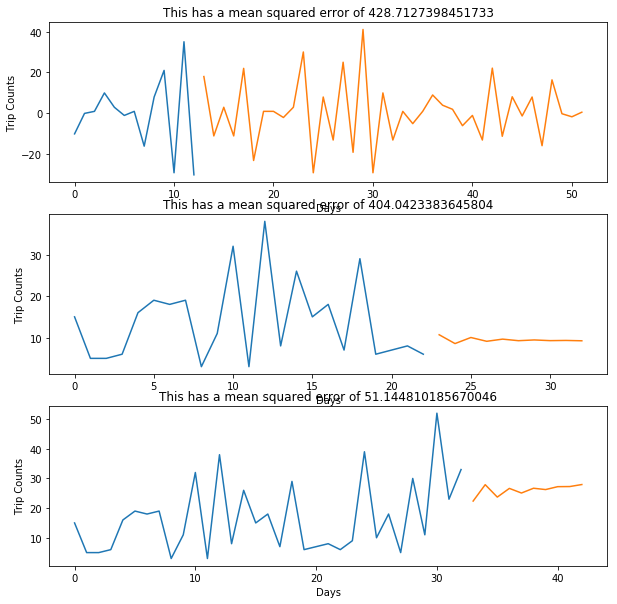

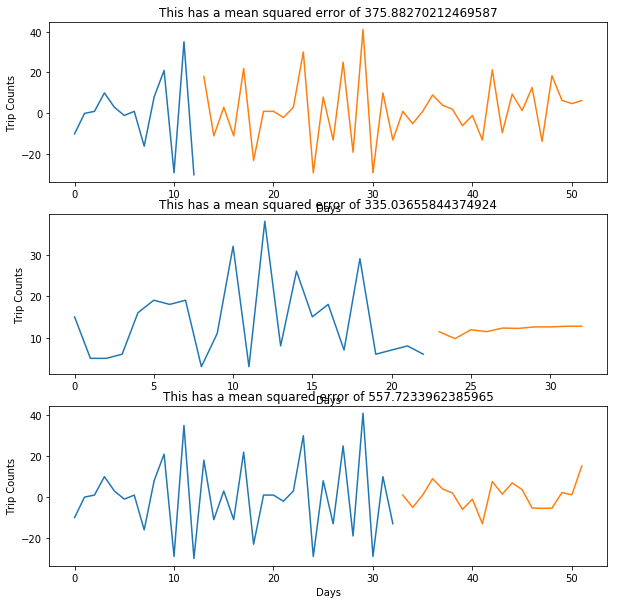

<Figure size 720x720 with 0 Axes>

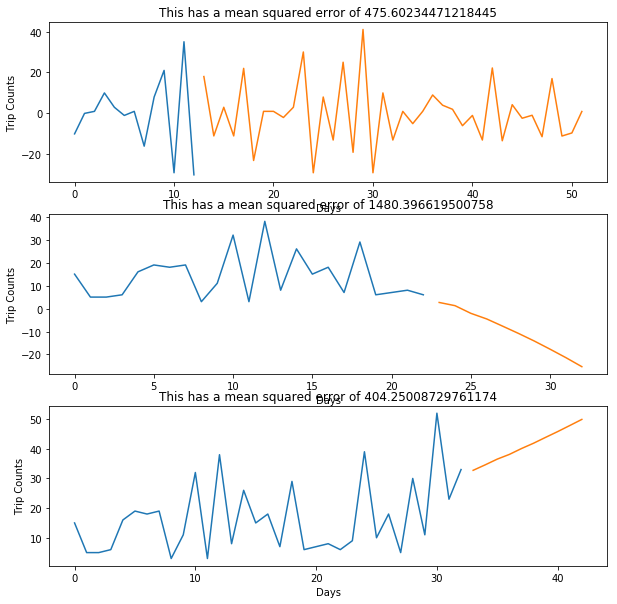

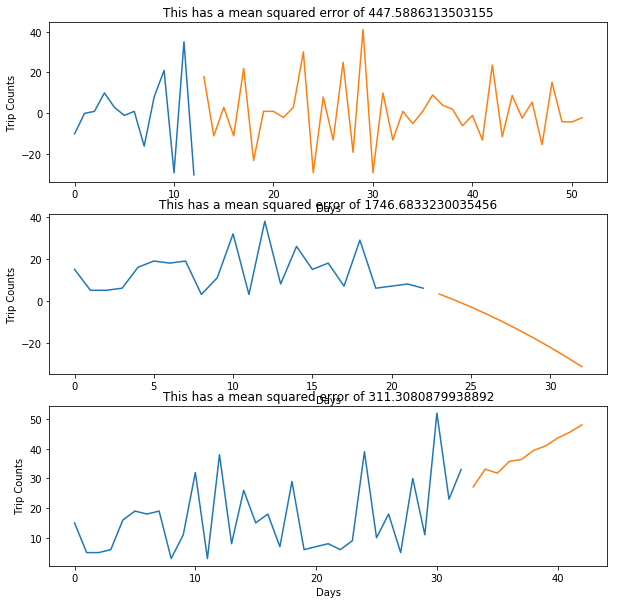

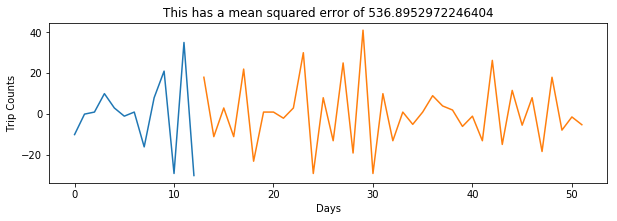

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

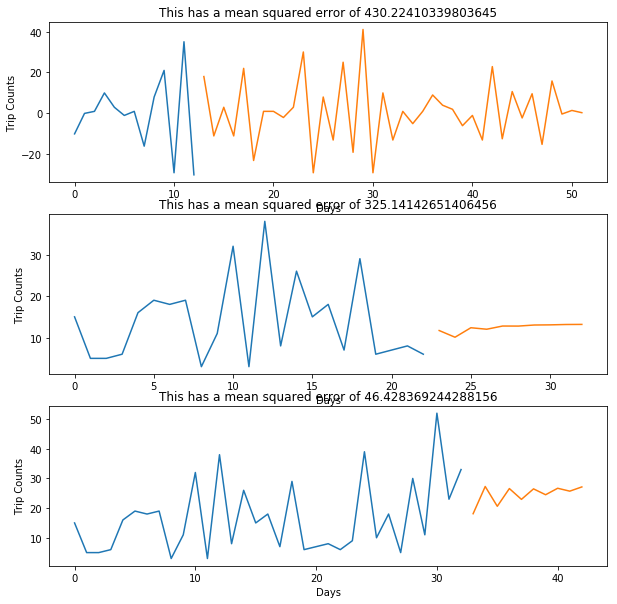

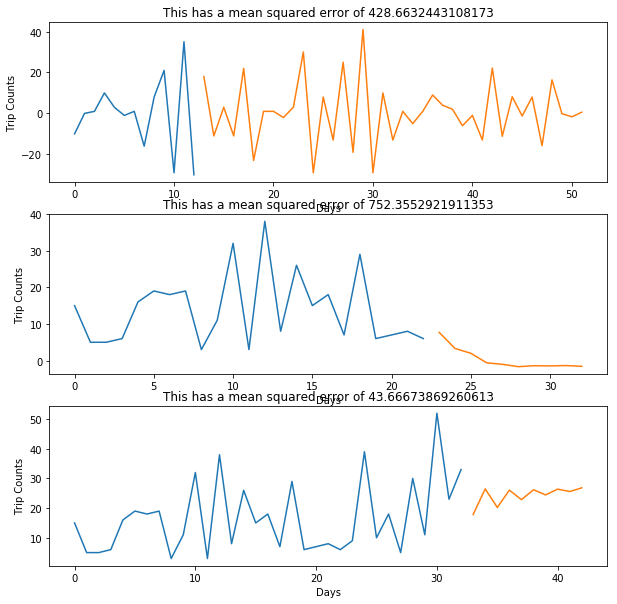

<Figure size 720x720 with 0 Axes>

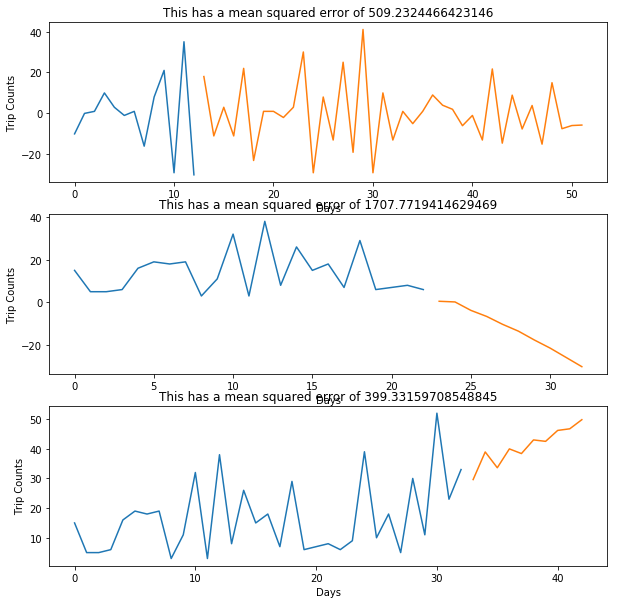

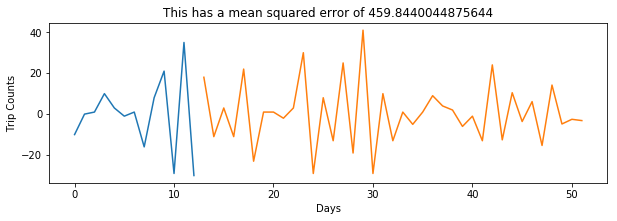

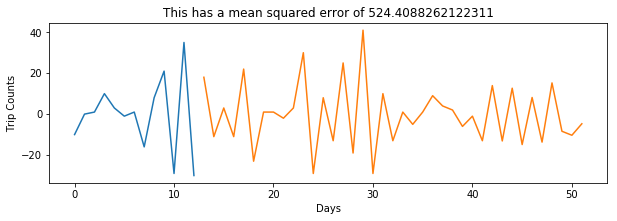

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [39]:
score = best_ARIMA_param(ts)

In [40]:
score

array([[  1.        ,   1.        ,   1.        , 344.85626164],
       [  1.        ,   2.        ,   2.        , 827.35253303],
       [  2.        ,   1.        ,   1.        , 294.63329613],
       [  2.        ,   1.        ,   2.        , 422.8808856 ],
       [  2.        ,   2.        ,   1.        , 786.74968384],
       [  2.        ,   2.        ,   2.        , 835.19334745],
       [  3.        ,   1.        ,   1.        , 267.26463305],
       [  3.        ,   1.        ,   2.        , 408.22842506],
       [  3.        ,   2.        ,   1.        , 872.11199506]])

In [41]:
np.sort(score[:,2]).reshape(-1,1)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.]])

In [42]:
np.sort(score[:,3]).reshape(-1,1)[0]

array([267.26463305])

In [43]:
score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]

array([False, False, False, False, False, False,  True, False, False])

In [44]:
score[score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]]

array([[  3.        ,   1.        ,   1.        , 267.26463305]])

In [45]:
score[score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]]

array([[  3.        ,   1.        ,   1.        , 267.26463305]])

In [46]:
score

array([[  1.        ,   1.        ,   1.        , 344.85626164],
       [  1.        ,   2.        ,   2.        , 827.35253303],
       [  2.        ,   1.        ,   1.        , 294.63329613],
       [  2.        ,   1.        ,   2.        , 422.8808856 ],
       [  2.        ,   2.        ,   1.        , 786.74968384],
       [  2.        ,   2.        ,   2.        , 835.19334745],
       [  3.        ,   1.        ,   1.        , 267.26463305],
       [  3.        ,   1.        ,   2.        , 408.22842506],
       [  3.        ,   2.        ,   1.        , 872.11199506]])

In [47]:
def best_params(score):
    best_params = score[score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]]
    return best_params

In [48]:
b_params = best_params(score)

In [49]:
def forecast_nxt_30d(ts, b_params):
    tseries = pd.Series(ts[:,1])
    p = int(b_params[0][0])
    d = int(b_params[0][1])
    q = int(b_params[0][2])
    
    current_vals = tseries.values
    trip_model = ARIMA(current_vals, order=(p, d, q)).fit()

    train_sze = len(current_vals)
#     predictions = trip_model.predict(train_sze, train_sze+30, typ='levels')
    predictions = trip_model.predict(90, 120, typ='levels')

    #combine to plot on same graph
    combined = np.append(current_vals, predictions)
    combined = pd.Series(combined)
    plt.xlabel('Days')
    plt.ylabel('Trip Counts')
#     plt.title('This has a mean squared error of {}'.format(mse))
    plt.plot(combined.index[:train_sze], combined[:train_sze], label="train")
    plt.plot(combined.index[train_sze:], combined[train_sze:], label='predicted')
    
    next_month_avg_pred = np.round(predictions.mean(), decimals=2)
    return next_month_avg_pred

In [50]:
tseries = pd.Series(ts[:,1])
current_vals= tseries.values
current_vals

array([15,  5,  5,  6, 16, 19, 18, 19,  3, 11, 32,  3, 38,  8, 26, 15, 18,
        7, 29,  6,  7,  8,  6,  9, 39, 10, 18,  5, 30, 11, 52, 23, 33, 20,
       21, 16, 17, 26, 30, 32, 26, 25, 12])

In [51]:
forcast_nxt_30d(ts, b_params)

NameError: name 'ARIMA' is not defined

In [ ]:
ndf.head(2)

In [ ]:
val_df = ndf[ndf.end_station_id == test_station]
count = val_df.day.value_counts()
actual_trips_per_day = np.array(count).mean()

In [ ]:
actual_trips_per_day

In [ ]:
neighbors

## apply predictions to neighbor statoins

In [52]:
def ready_set_go(qtr,cdf,neighbors):
    #stores the proposed location's stations id and its neighbors' overall average trip count per day
    trend = {}
    #get the orgin station and its neighbor
    for k, v in neighbors.items():
        
        avg_temp = []
        #access each neighbor for station k
        for s in v:
            try:
                print ("This is station {}, and the neighbor is {}".format(k,s))

                #time series data for station s
                ts = days_count(qtr,s)

                #scores for each ARIMA hyper parameter combination
                score = best_ARIMA_param(ts)

                #best hyper parameter for the model
                #based on smallest MSE
                b_params = best_params(score)

                #average prediction of trips per day for the next month
                avg_pred = forecast_nxt_30d(ts, b_params)
                avg_temp.append(avg_pred)
            except:
                print ("Combination did not work")
        neigh_avg = np.array(avg_temp)
        trend[k] = neigh_avg
    return trend

This is station 130, and the neighbor is 126
The hyper parameters 1, 1, and 1 did not work.
The hyper parameters 1, 1, and 2 did not work.
The hyper parameters 1, 1, and 3 did not work.
The hyper parameters 1, 2, and 1 did not work.
The hyper parameters 1, 2, and 2 did not work.
The hyper parameters 1, 2, and 3 did not work.
The hyper parameters 1, 3, and 1 did not work.
The hyper parameters 1, 3, and 2 did not work.
The hyper parameters 1, 3, and 3 did not work.
The hyper parameters 2, 1, and 1 did not work.
The hyper parameters 2, 1, and 2 did not work.
The hyper parameters 2, 1, and 3 did not work.
The hyper parameters 2, 2, and 1 did not work.
The hyper parameters 2, 2, and 2 did not work.
The hyper parameters 2, 2, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in reduce
  umr_maximum(a, axis, None, out, keepdims),
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in reduce
  umr_minimum(a, axis, None, None, keepdims),


The hyper parameters 2, 3, and 1 did not work.
The hyper parameters 2, 3, and 2 did not work.
The hyper parameters 2, 3, and 3 did not work.
The hyper parameters 3, 1, and 1 did not work.
The hyper parameters 3, 1, and 2 did not work.
The hyper parameters 3, 1, and 3 did not work.
The hyper parameters 3, 2, and 1 did not work.
The hyper parameters 3, 2, and 2 did not work.
The hyper parameters 3, 2, and 3 did not work.
The hyper parameters 3, 3, and 1 did not work.
The hyper parameters 3, 3, and 2 did not work.
The hyper parameters 3, 3, and 3 did not work.
This is the array of scores
Combination did not work
This is station 130, and the neighbor is 116


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


The hyper parameters 1, 1, and 2 did not work.
The hyper parameters 1, 1, and 3 did not work.
The hyper parameters 1, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


The hyper parameters 1, 2, and 3 did not work.
The hyper parameters 1, 3, and 1 did not work.
The hyper parameters 1, 3, and 2 did not work.
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linea

The hyper parameters 2, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyp

The hyper parameters 2, 2, and 3 did not work.
The hyper parameters 2, 3, and 1 did not work.
The hyper parameters 2, 3, and 2 did not work.
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

The hyper parameters 3, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

The hyper parameters 3, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


The hyper parameters 3, 2, and 3 did not work.
The hyper parameters 3, 3, and 1 did not work.
The hyper parameters 3, 3, and 2 did not work.
The hyper parameters 3, 3, and 3 did not work.
This is the array of scores
This is station 130, and the neighbor is 115


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 1, 1, and 2 did not work.
The hyper parameters 1, 1, and 3 did not work.
The hyper parameters 1, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:665: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:666: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or 

The hyper parameters 1, 2, and 2 did not work.
The hyper parameters 1, 2, and 3 did not work.
The hyper parameters 1, 3, and 1 did not work.
The hyper parameters 1, 3, and 2 did not work.
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:6

The hyper parameters 2, 1, and 2 did not work.
The hyper parameters 2, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 2, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 2, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:507: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and 

The hyper parameters 2, 2, and 3 did not work.
The hyper parameters 2, 3, and 1 did not work.
The hyper parameters 2, 3, and 2 did not work.
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:507: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/matp

The hyper parameters 3, 1, and 2 did not work.
The hyper parameters 3, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 3, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 3, 2, and 3 did not work.
The hyper parameters 3, 3, and 1 did not work.
The hyper parameters 3, 3, and 2 did not work.
The hyper parameters 3, 3, and 3 did not work.
This is the array of scores
This is station 118, and the neighbor is 119
The hyper parameters 1, 1, and 1 did not work.
The hyper parameters 1, 1, and 2 did not work.
The hyper parameters 1, 1, and 3 did not work.
The hyper parameters 1, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 1, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 1, 2, and 3 did not work.
The hyper parameters 1, 3, and 1 did not work.
The hyper parameters 1, 3, and 2 did not work.
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:6

The hyper parameters 2, 1, and 2 did not work.
The hyper parameters 2, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 2, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:507: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and 

The hyper parameters 2, 2, and 3 did not work.
The hyper parameters 2, 3, and 1 did not work.
The hyper parameters 2, 3, and 2 did not work.
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 3, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 3, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 3, 2, and 3 did not work.
The hyper parameters 3, 3, and 1 did not work.
The hyper parameters 3, 3, and 2 did not work.
The hyper parameters 3, 3, and 3 did not work.
This is the array of scores
This is station 118, and the neighbor is 105


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 1, 1, and 2 did not work.
The hyper parameters 1, 1, and 3 did not work.
The hyper parameters 1, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:507: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 1, 3, and 1 did not work.
The hyper parameters 1, 3, and 2 did not work.
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: 

The hyper parameters 2, 1, and 2 did not work.
The hyper parameters 2, 1, and 3 did not work.
The hyper parameters 2, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:507: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matp

The hyper parameters 2, 2, and 3 did not work.
The hyper parameters 2, 3, and 1 did not work.
The hyper parameters 2, 3, and 2 did not work.
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume

The hyper parameters 3, 1, and 3 did not work.
The hyper parameters 3, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:6

The hyper parameters 3, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 3, 3, and 1 did not work.
The hyper parameters 3, 3, and 2 did not work.
The hyper parameters 3, 3, and 3 did not work.
This is the array of scores
This is station 118, and the neighbor is 106
The hyper parameters 1, 1, and 1 did not work.
The hyper parameters 1, 1, and 2 did not work.
The hyper parameters 1, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in reduce
  umr_maximum(a, axis, None, out, keepdims),
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in reduce
  umr_minimum(a, axis, None, None, keepdims),


The hyper parameters 1, 2, and 1 did not work.
The hyper parameters 1, 2, and 2 did not work.
The hyper parameters 1, 2, and 3 did not work.
The hyper parameters 1, 3, and 1 did not work.
The hyper parameters 1, 3, and 2 did not work.
The hyper parameters 1, 3, and 3 did not work.
The hyper parameters 2, 1, and 1 did not work.
The hyper parameters 2, 1, and 2 did not work.
The hyper parameters 2, 1, and 3 did not work.
The hyper parameters 2, 2, and 1 did not work.
The hyper parameters 2, 2, and 2 did not work.
The hyper parameters 2, 2, and 3 did not work.
The hyper parameters 2, 3, and 1 did not work.
The hyper parameters 2, 3, and 2 did not work.
The hyper parameters 2, 3, and 3 did not work.
The hyper parameters 3, 1, and 1 did not work.
The hyper parameters 3, 1, and 2 did not work.
The hyper parameters 3, 1, and 3 did not work.
The hyper parameters 3, 2, and 1 did not work.
The hyper parameters 3, 2, and 2 did not work.
The hyper parameters 3, 2, and 3 did not work.
The hyper par

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

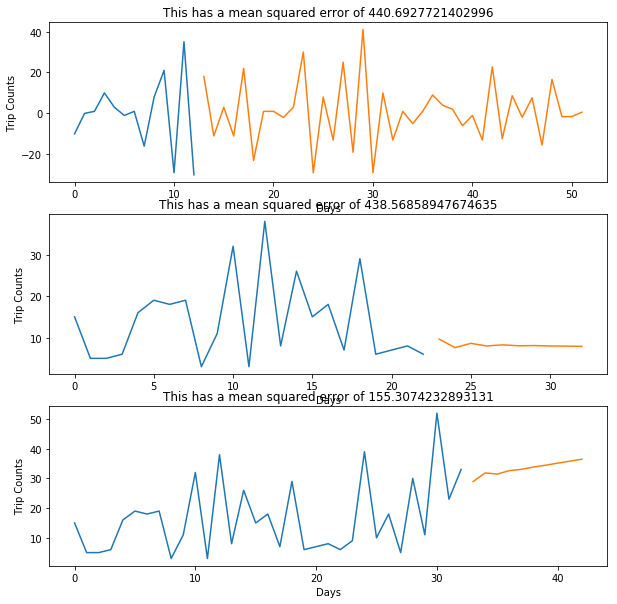

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

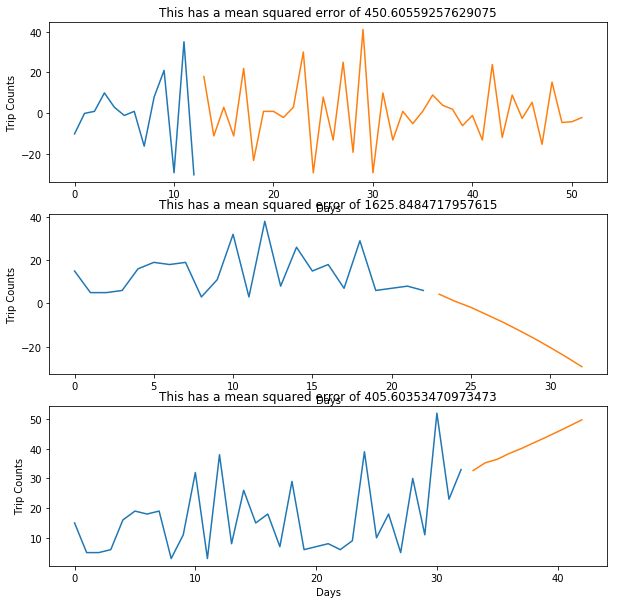

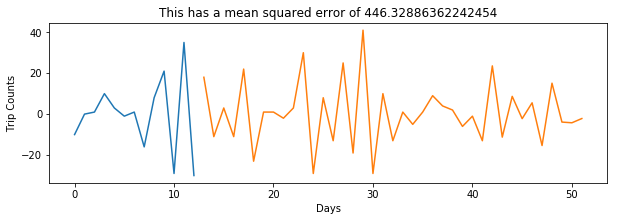

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

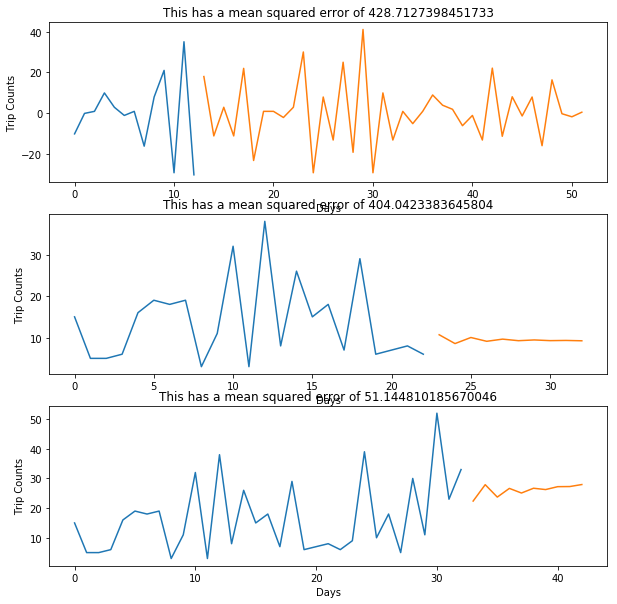

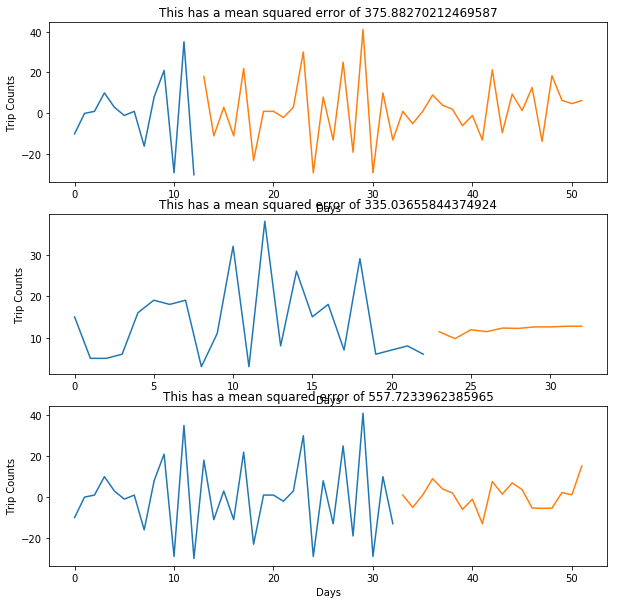

<Figure size 720x720 with 0 Axes>

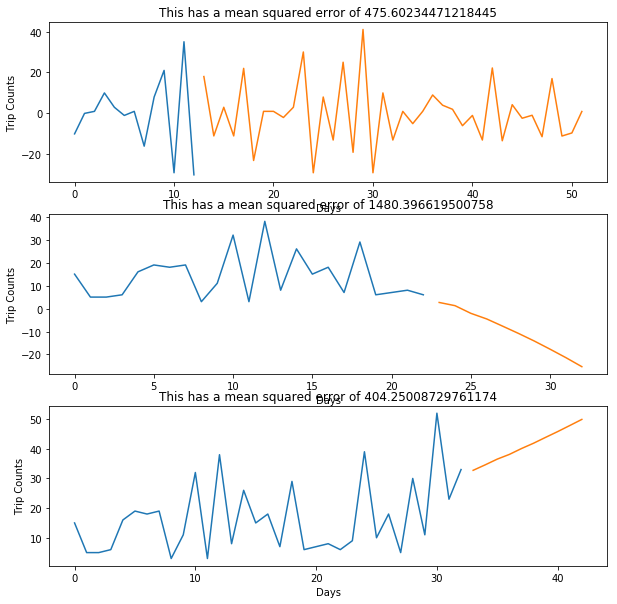

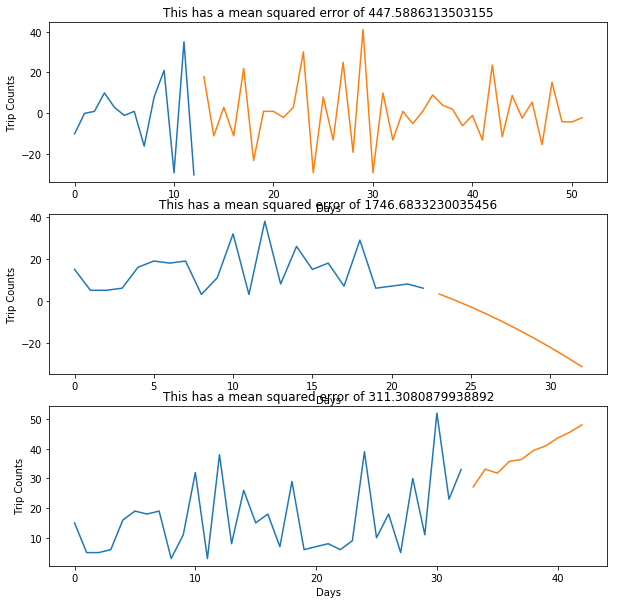

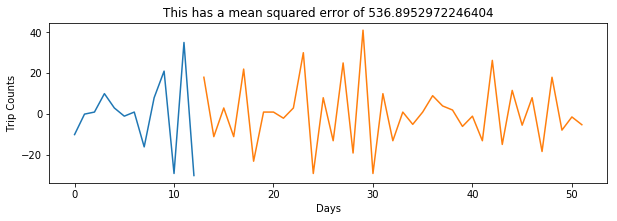

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

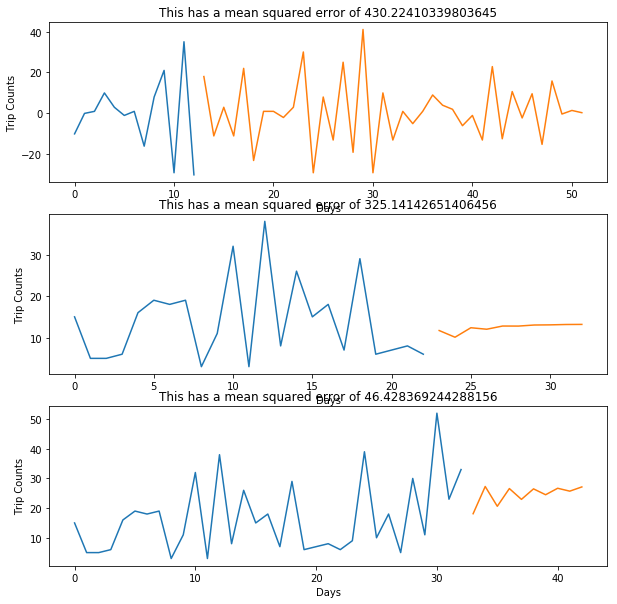

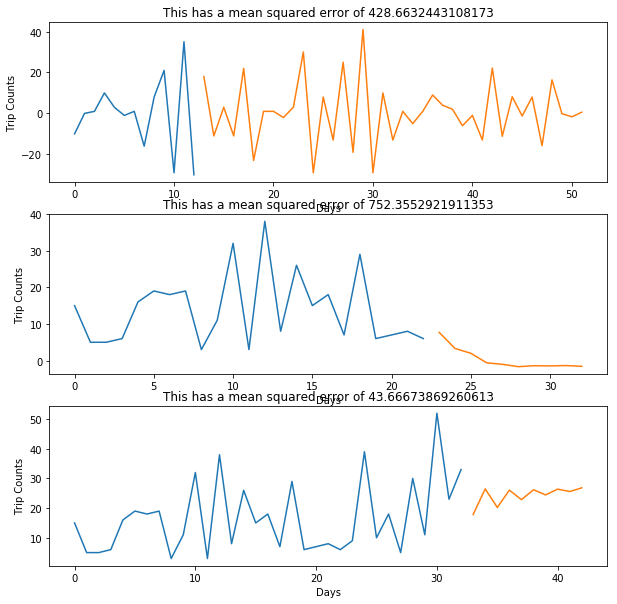

<Figure size 720x720 with 0 Axes>

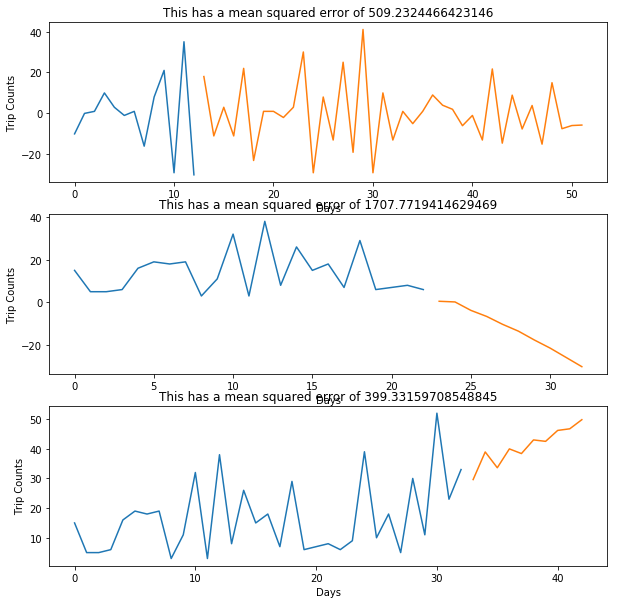

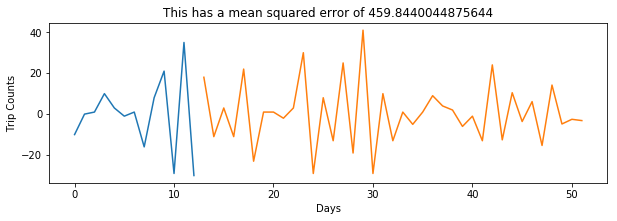

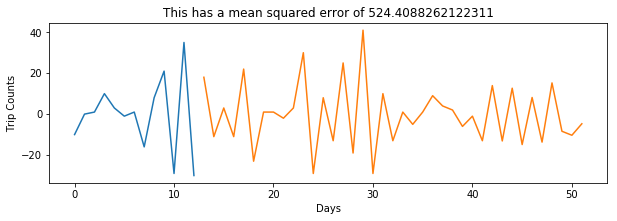

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

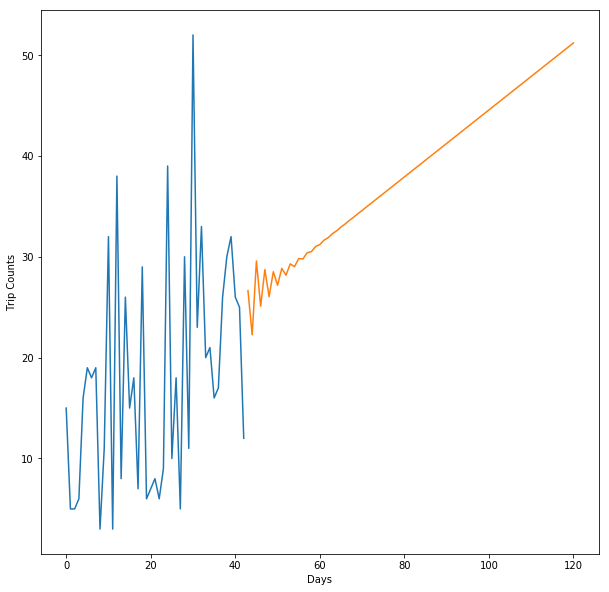

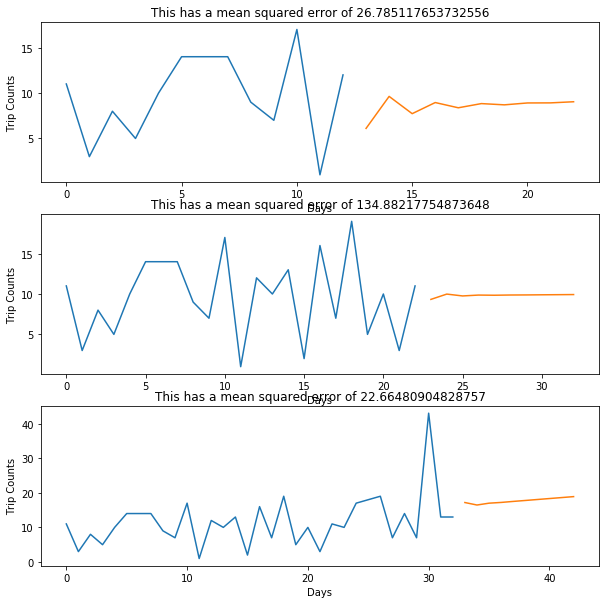

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

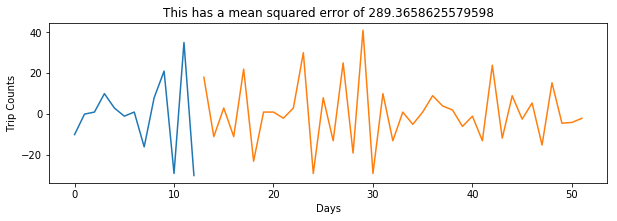

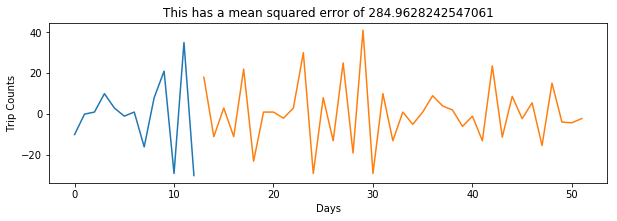

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

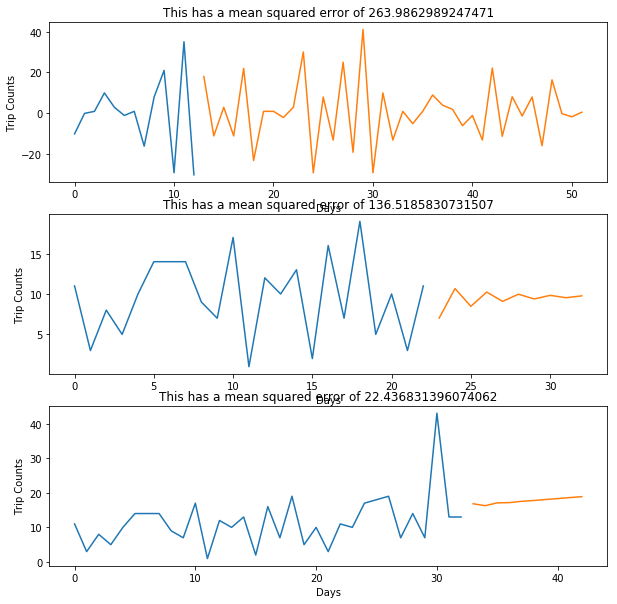

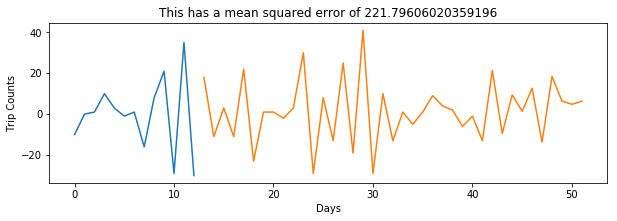

<Figure size 720x720 with 0 Axes>

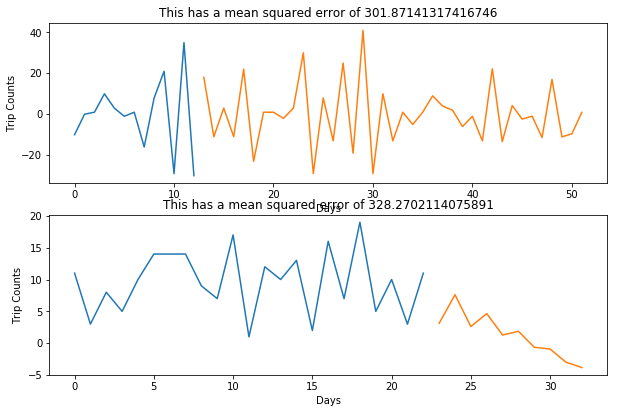

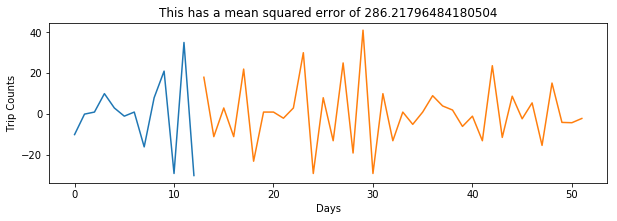

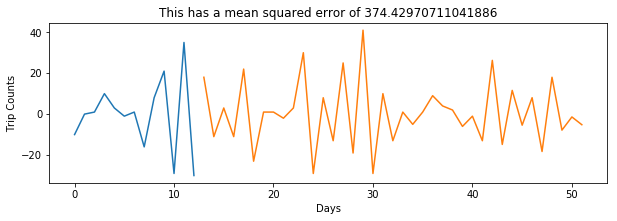

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

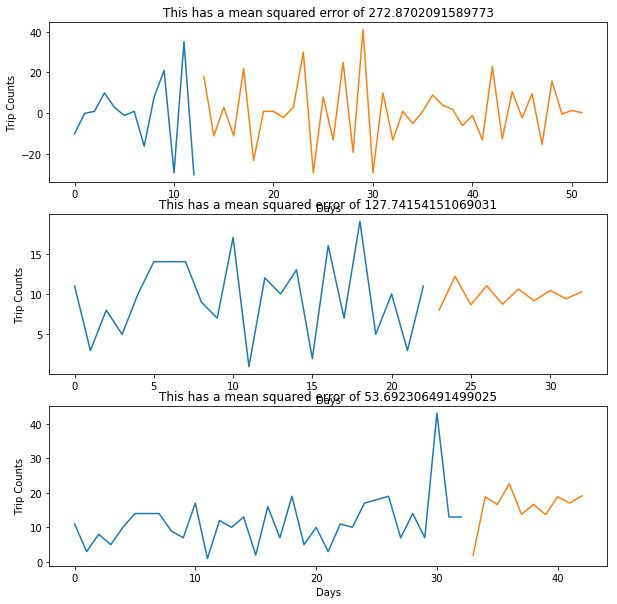

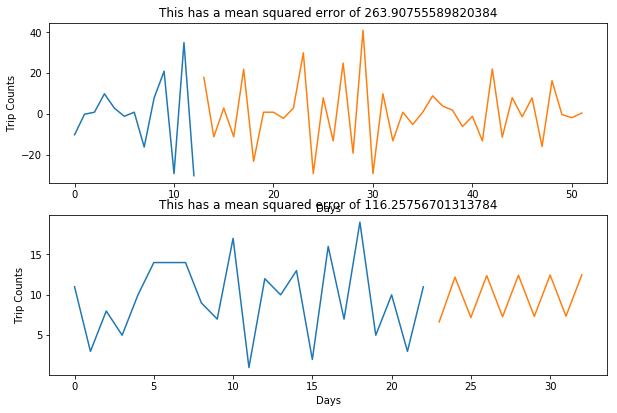

<Figure size 720x720 with 0 Axes>

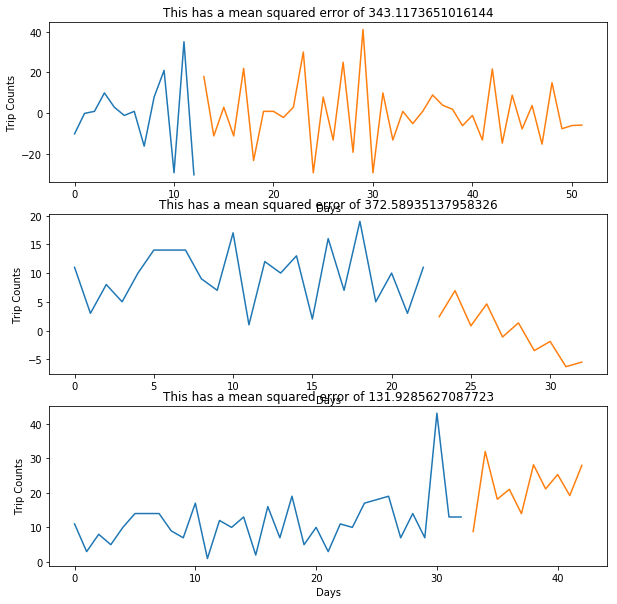

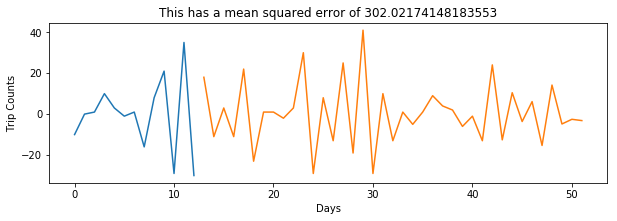

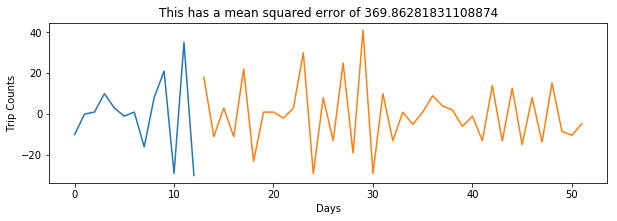

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

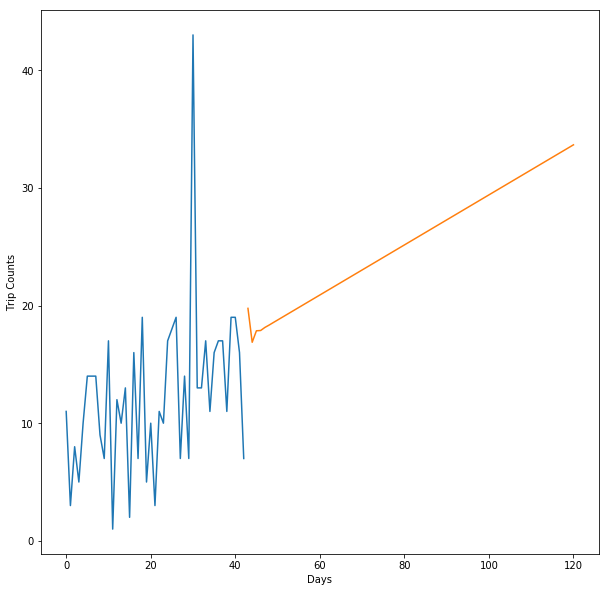

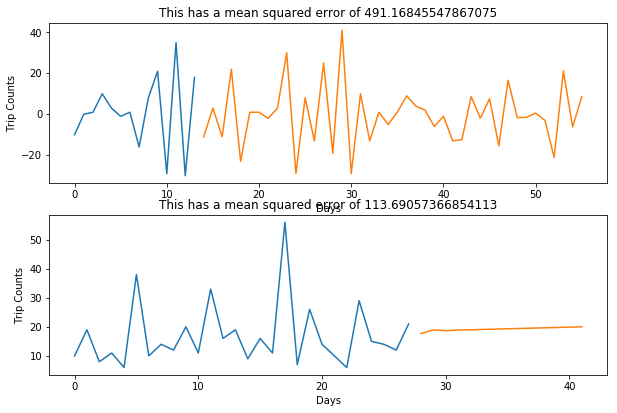

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

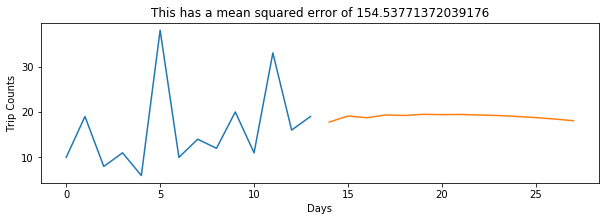

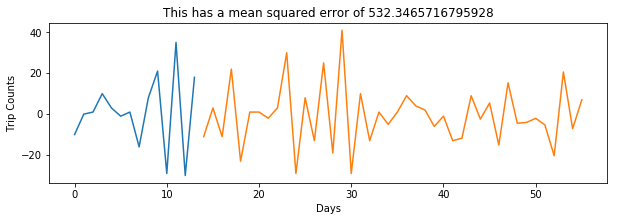

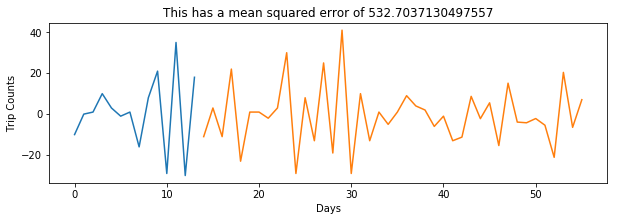

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

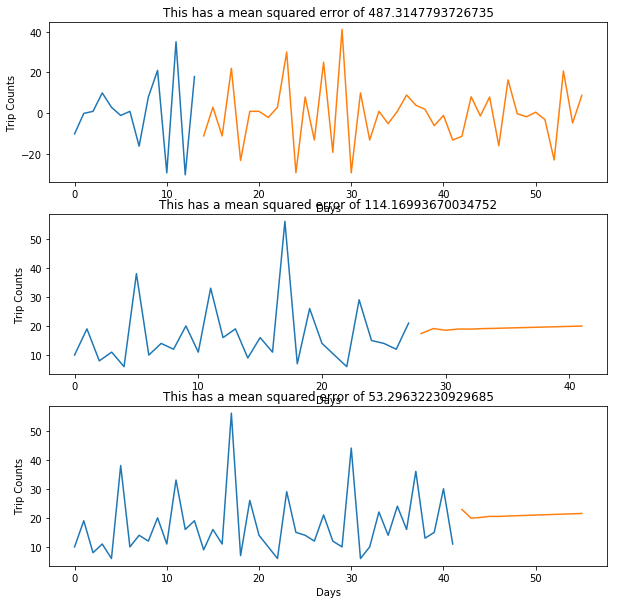

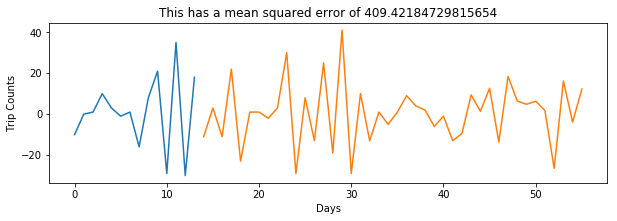

<Figure size 720x720 with 0 Axes>

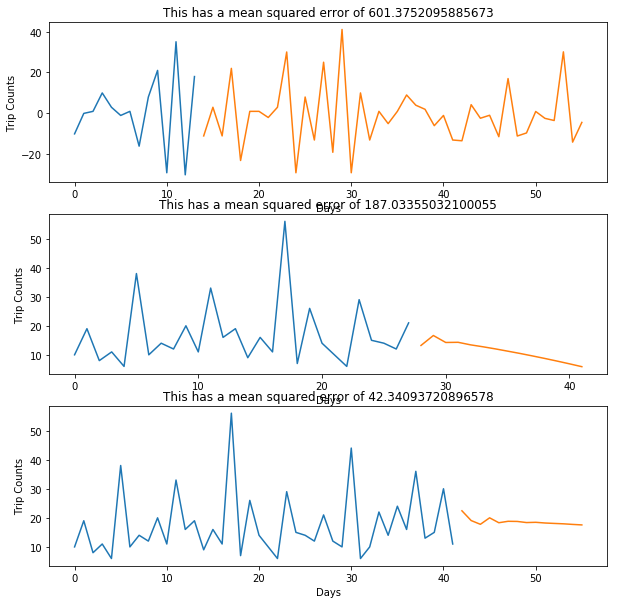

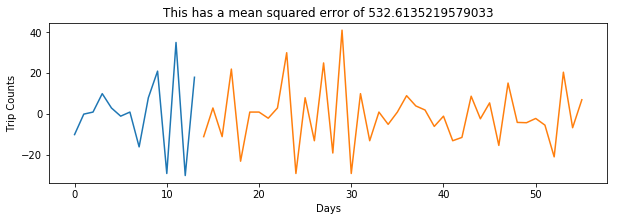

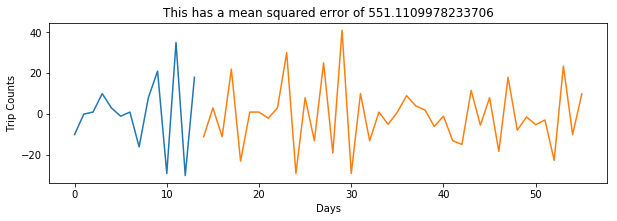

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

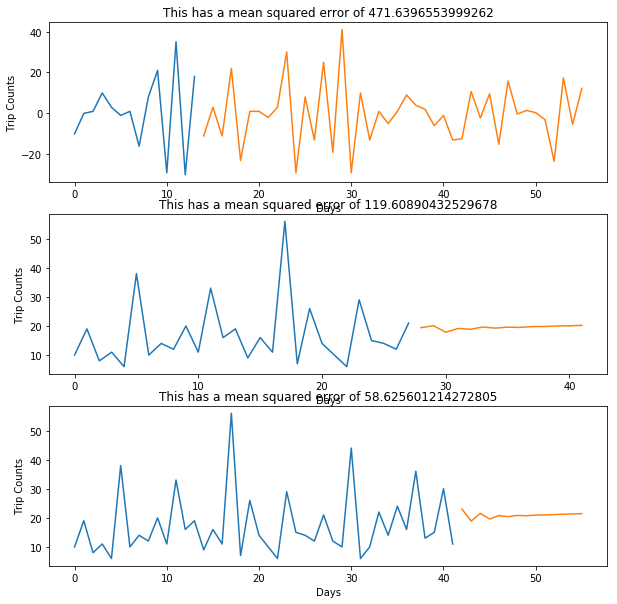

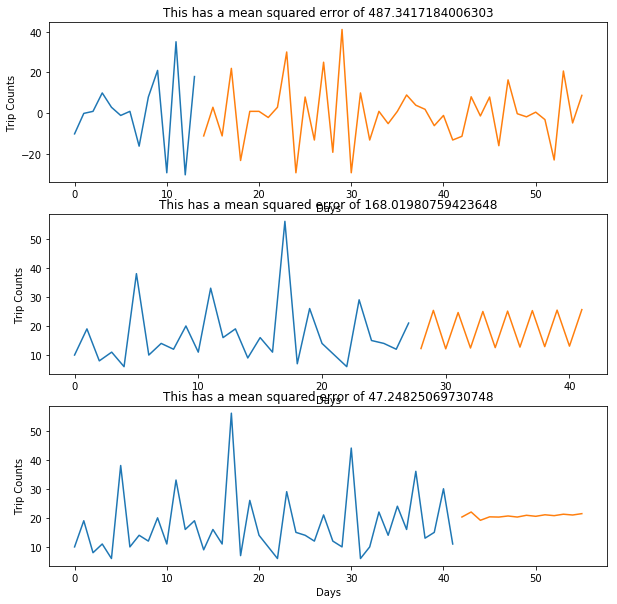

<Figure size 720x720 with 0 Axes>

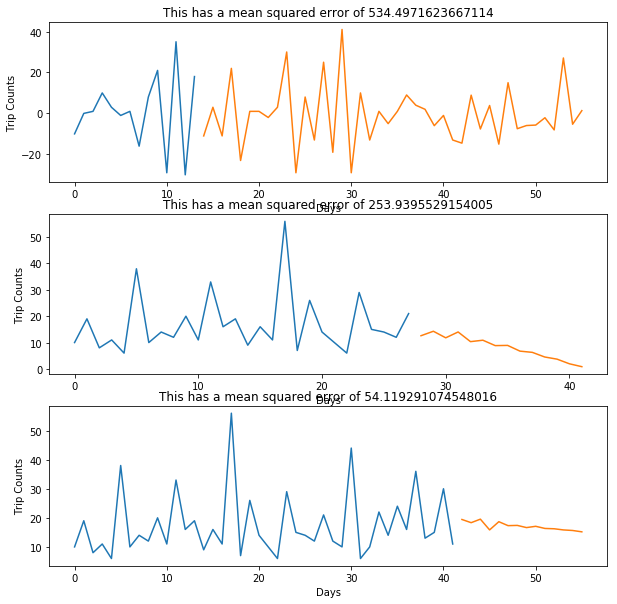

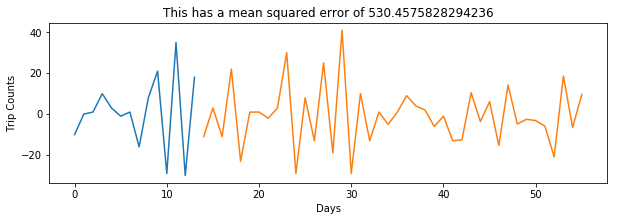

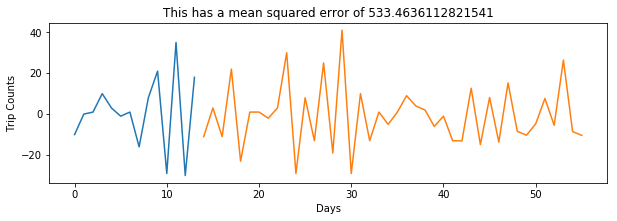

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

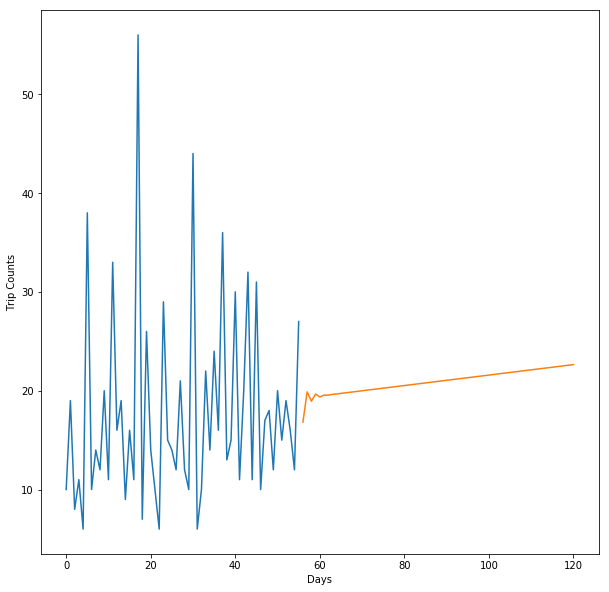

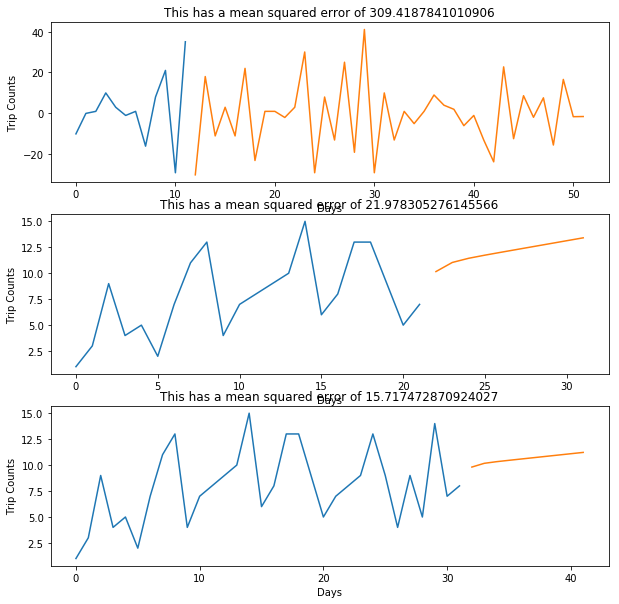

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

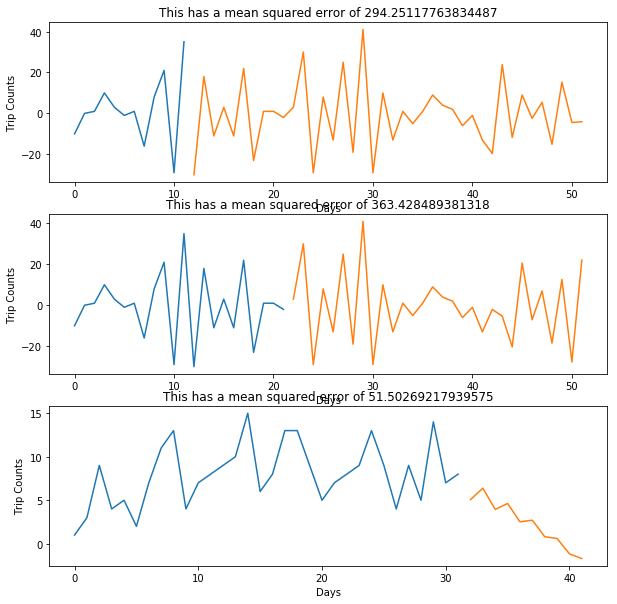

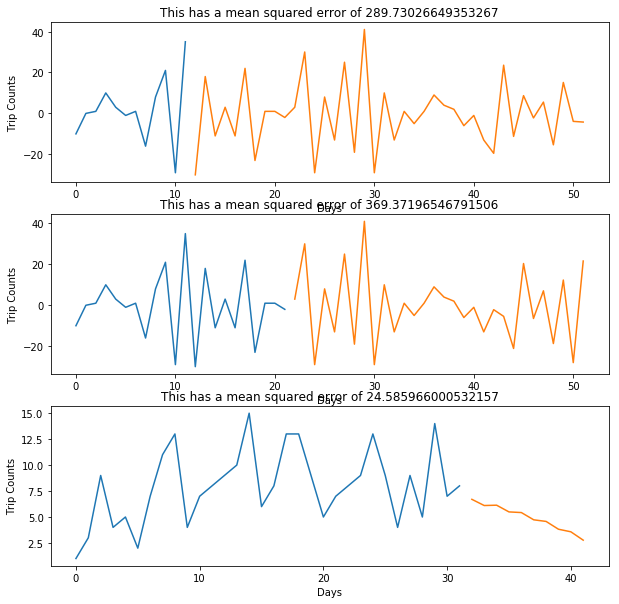

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

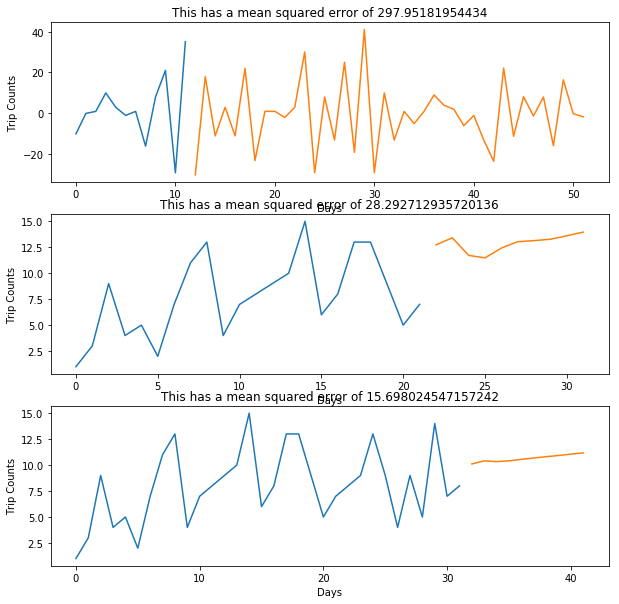

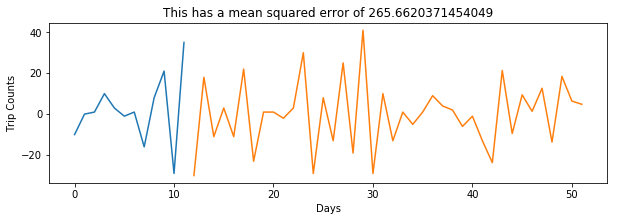

<Figure size 720x720 with 0 Axes>

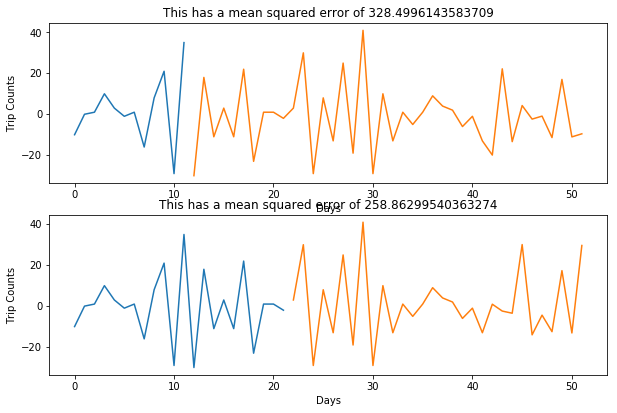

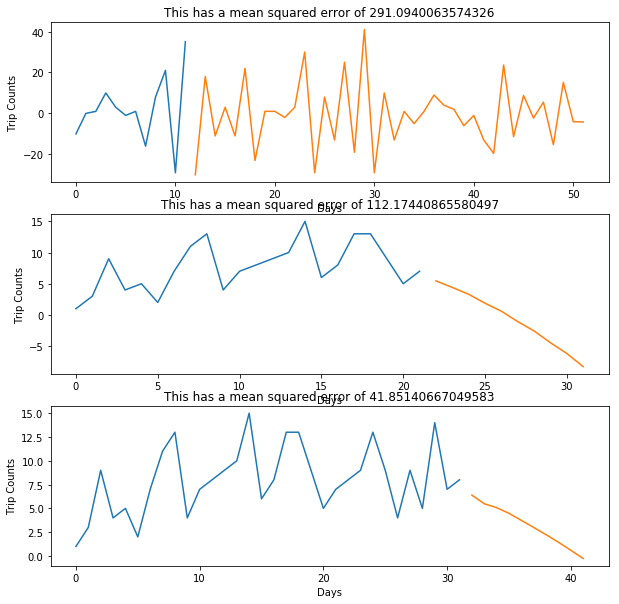

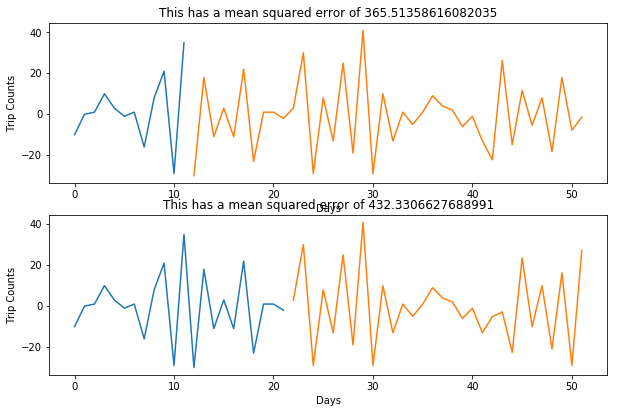

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

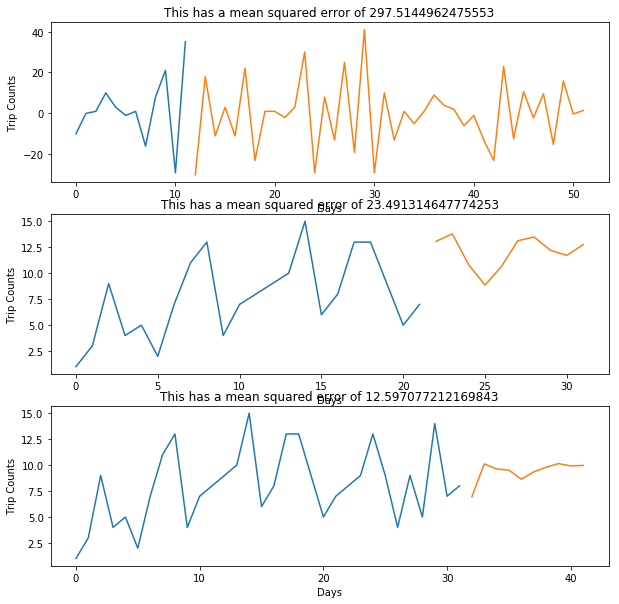

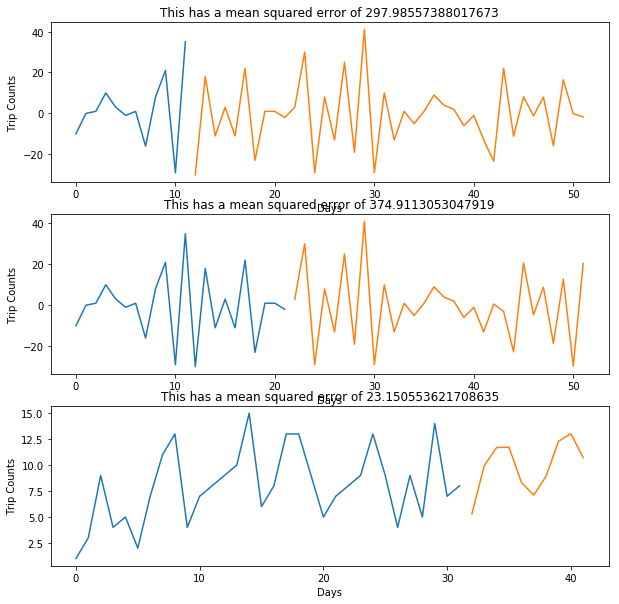

<Figure size 720x720 with 0 Axes>

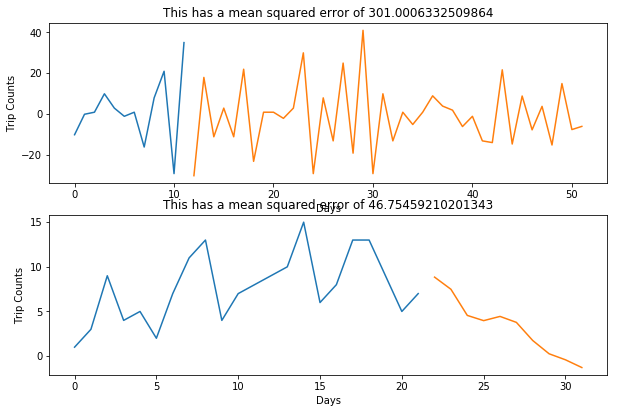

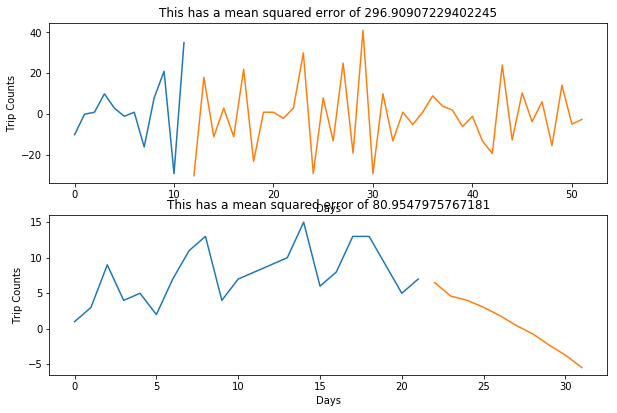

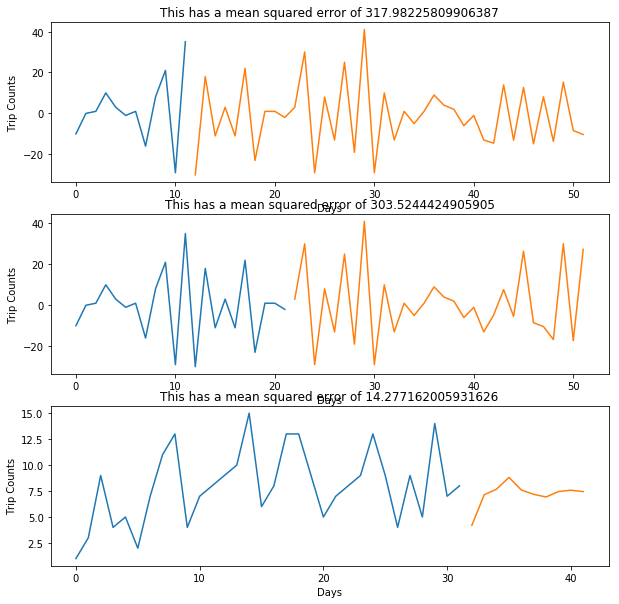

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

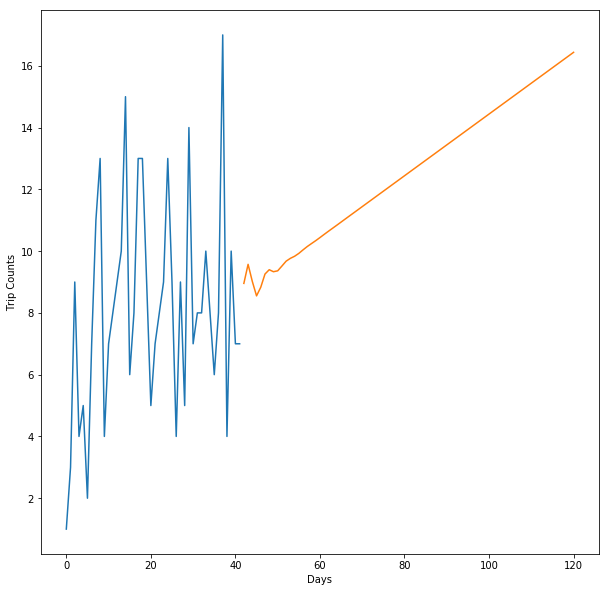

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [53]:
trend = ready_set_go(qtr,cdf, neighbors)

In [54]:
trend

{130: array([38.42, 25.49]), 118: array([20.92, 12.55])}

In [65]:
def validate(trend, ndf):
    
    #validate the stations in the trend dictionary
    for k, v in trend.items():
        
        #mean of forecasted values
        neighbor_mean = v.mean()
        
        #using the following month's data to calculate actual trips per day
        count = ndf[ndf.end_station_id == test_station]["day"].value_counts()
        actual_trips_per_day = np.array(count).mean()
        
        #calc baseline estimate
        baseline_est = 
        
        
        
        
        print ("Validating for station {}".format(k))
        print ("The baseline estimate using the mean for neighboring station is {}".format())
        print ("The average predicted trip count per day is {}.".format(neighbor_mean)) 
        print ("The actual trips per day for the following month is {}.".format(actual_trips_per_day))


SyntaxError: invalid syntax (<ipython-input-65-47aca326f776>, line 13)

In [64]:
validate(trend, ndf)

The predicted mean for station 130's neighboring stations is 31.955, and the actual trips per day for the following month is 17.29032258064516.
The predicted mean for station 118's neighboring stations is 16.735, and the actual trips per day for the following month is 17.29032258064516.


In [ ]:
ready_set_go()

In [ ]:
samp_dict = {}

In [ ]:
samp_dict[[1,2,3]] = 2

In [ ]:
# #Print MSE to see how good the model is
# Error = mean_squared_error(TestData, Predictions)
# print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)
# # plot
# pyplot.plot(TestData)
# pyplot.plot(Predictions, color='red')
# pyplot.show()

In [ ]:
# #in a for loop, predict values using ARIMA model
# for timepoint in range(len(TestData)):
#     ActualValue =  TestData[timepoint]
#     #forcast value
#     Prediction = StartARIMAForecasting(Actual, 3,1,0)    
#     print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
#     Predictions.append(Prediction)
#     Actual.append(ActualValue)